In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting the data 
import seaborn as sns # Advanced data plotting on top of matplotlib
import os


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import cv2
from PIL import Image
from matplotlib import pyplot as plt


In [2]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
#/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv
#/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv
#/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv
#/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv    

**About data**

*images* - a folder of images corresponding to each article_id; images are placed in subfolders starting with the first three digits of the article_id; note, not all article_id values have a corresponding image.

*articles.csv* - detailed metadata for each article_id available for purchase

*customers.csv* - metadata for each customer_id in dataset

*sample_submission.csv* - a sample submission file in the correct format

*transactions_train.csv* - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period.

*target*: Make predictions for all customer_id values found in the sample submission. All customers who made purchases during the test period are scored, regardless of whether they had purchase history in the training data.

Submissions are evaluated according to the Mean Average Precision @ 12 (MAP@12).
For each customer_id observed in the training data, you may predict up to 12 labels for the article_id, which is the predicted items a customer will buy in the next 7-day period after the training time period. 

# EDA

In [3]:
#customers_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv")
#sample_submission = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv" )
#customers_df.head()

In [4]:
transactions_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")#, nrow=10000)
print(transactions_df.shape)
transactions_df.head()

(31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [5]:
# let's takr peace of data
transactions_df_sample = transactions_df.iloc[:200000,:].copy()
transactions_df_sample.shape

(200000, 5)

In [6]:
articles_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
print(articles_df.shape)
articles_df.head().T  

(105542, 25)


,0,1,2,3,4
article_id,108775015,108775044,108775051,110065001,110065002
product_code,108775,108775,108775,110065,110065
prod_name,Strap top,Strap top,Strap top (1),OP T-shirt (Idro),OP T-shirt (Idro)
product_type_no,253,253,253,306,306
product_type_name,Vest top,Vest top,Vest top,Bra,Bra
product_group_name,Garment Upper body,Garment Upper body,Garment Upper body,Underwear,Underwear
graphical_appearance_no,1010016,1010016,1010017,1010016,1010016
graphical_appearance_name,Solid,Solid,Stripe,Solid,Solid
colour_group_code,9,10,11,9,10
colour_group_name,Black,White,Off White,Black,White


In [7]:
# Number of unique meanings of article features
for col in articles_df.columns:
    print(col, len(articles_df[col].unique()))
    

article_id 105542
product_code 47224
prod_name 45875
product_type_no 132
product_type_name 131
product_group_name 19
graphical_appearance_no 30
graphical_appearance_name 30
colour_group_code 50
colour_group_name 50
perceived_colour_value_id 8
perceived_colour_value_name 8
perceived_colour_master_id 20
perceived_colour_master_name 20
department_no 299
department_name 250
index_code 10
index_name 10
index_group_no 5
index_group_name 5
section_no 57
section_name 56
garment_group_no 21
garment_group_name 21
detail_desc 43405


In [8]:
articles_df['index_group_name'].unique()

array(['Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'],
      dtype=object)

In [9]:
# Number of unique meanings  of customers and articles
print(len(transactions_df_sample.customer_id.unique()))
print(len(transactions_df_sample.article_id.unique()))

51527
19519


In [10]:
print(transactions_df_sample.groupby("customer_id")["article_id"].count().mean())
transactions_df_sample.groupby("customer_id")["article_id"].count().value_counts()

3.881460205329245


1      13984
2      11085
3       7350
4       5118
5       3313
6       2589
7       1775
8       1452
9       1050
10       787
11       602
12       445
13       365
14       283
15       237
16       179
17       144
19       117
18       114
20        94
21        60
24        55
22        48
23        42
25        34
26        34
28        27
27        20
31        17
29        16
32        13
30        11
33        10
37         8
36         7
34         7
39         5
35         4
40         4
52         3
38         2
48         2
42         2
46         1
103        1
55         1
80         1
43         1
51         1
44         1
54         1
45         1
41         1
100        1
47         1
72         1
Name: article_id, dtype: int64

In [11]:
print(transactions_df_sample.groupby("article_id")["customer_id"].count().value_counts().mean())
transactions_df_sample.groupby("article_id")["customer_id"].count().value_counts()

92.07075471698113


1      5114
2      2743
3      1901
4      1372
5      1069
       ... 
163       1
143       1
392       1
189       1
169       1
Name: customer_id, Length: 212, dtype: int64

In [12]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
transactions_df_sample[['article_id_enc', 'customer_id_enc']] = enc.fit_transform(transactions_df_sample[['article_id', 'customer_id']]) 

transactions_df_sample.head()

,t_dat,customer_id,article_id,price,sales_channel_id,article_id_enc,customer_id_enc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,16743.0,1.0
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,3785.0,1.0
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,2464.0,2.0
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,18666.0,2.0
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,18667.0,2.0


In [13]:
transactions_df_sample['article_id_enc'] = transactions_df_sample['article_id_enc'].astype(int)
transactions_df_sample['customer_id_enc'] = transactions_df_sample['customer_id_enc'].astype(int)

In [14]:
item_features = articles_df[['product_type_no', 'index_group_no', 'garment_group_no', 'article_id']].copy()
item_features = item_features.merge(transactions_df_sample[['article_id_enc','article_id']].drop_duplicates(), how="left", on="article_id")
item_features.dropna(axis=0, inplace=True)
item_features['article_id_enc'] = item_features['article_id_enc'].astype(int)
item_features.set_index("article_id_enc", inplace=True)
item_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19519 entries, 0 to 19518
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   product_type_no   19519 non-null  int64
 1   index_group_no    19519 non-null  int64
 2   garment_group_no  19519 non-null  int64
 3   article_id        19519 non-null  int64
dtypes: int64(4)
memory usage: 762.5 KB


In [15]:
train_df, test_df = train_test_split(transactions_df_sample, test_size=0.1, random_state=42)

# Collaborative filtering 

In [16]:
import scipy.sparse as sp
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

from lightfm.cross_validation import random_train_test_split
from lightfm.data import Dataset


In [17]:
# Convert data to sparse matrix
# (np.float32 coo_matrix of shape [n_users, n_items]) – the matrix containing user-item interactions. 
# Will be converted to numpy.float32 dtype if it is not of that type.

data_sp = sp.coo_matrix((np.ones(train_df.shape[0]), (train_df.customer_id_enc.values, train_df.article_id_enc.values ) ))
data_sp.shape

(51527, 19519)

In [18]:
# build item features
# item_features (np.float32 csr_matrix of shape [n_items, n_item_features], optional) – Each row contains that item’s weights over features.
item_features_product_type_no = pd.get_dummies(item_features["index_group_no"])
item_features_product_type_no.shape

item_features_csr = sp.csr_matrix(item_features_product_type_no.values)
item_features_csr.shape

(19519, 5)

In [19]:
# Make split
train_sp, valid_sp = random_train_test_split(data_sp, test_percentage=0.2, random_state=42)

In [20]:
# Define the model

model = LightFM(no_components=30, loss='warp', random_state=42)
model.fit(train_sp, epochs=10, num_threads=2)

In [21]:
# Evaluate the model
print("Train AUC: %.2f" % auc_score(model, train_sp).mean())
print("Valid AUC: %.2f" % auc_score(model, valid_sp).mean())


Train AUC: 0.99
Valid AUC: 0.82


In [22]:
model.predict(train_df.customer_id_enc.values, train_df.article_id_enc.values)

array([0.67507815, 1.693158  , 2.1735713 , ..., 2.6026413 , 0.53546995,
       0.866274  ], dtype=float32)

In [23]:
# Model with item features
model2 = LightFM(no_components=40, loss='warp', random_state=42)
model2.fit(train_sp, item_features=item_features_csr, epochs=20, num_threads=2)

In [24]:
# Evaluate the model
print("Train AUC: %.2f" % auc_score(model2, train_sp, item_features=item_features_csr).mean())
print("Valid AUC: %.2f" % auc_score(model2, valid_sp, item_features=item_features_csr).mean())

Train AUC: 0.65
Valid AUC: 0.57


In [25]:
# Dictinary for index converting
article_dict = dict(zip(train_df["article_id_enc"].values, train_df["article_id"].values))


In [26]:
def sample_recommendation(model, transactions_df, articles_df, article_dict, num, user_ids):

    items = transactions_df.article_id_enc.unique()
    #print(items[:10])

    for user_id in user_ids:
        print()
        print("*" * 60)
        print("  Recomendations for user_id =", user_id)
        print("*" * 60)
        
        print("\n     Already bought:")
        rtg = transactions_df[transactions_df["customer_id_enc"] == user_id]["article_id"].values
        
        #print("{:10}  {:25} {:20} {:20} {:40}".format("id", "prod name", "product type name","index group name", "section name"))
        #print()

        for item in rtg:           
            print("{:10}  {:25} {:20} {:20} {:40}".format(item, articles_df.loc[item, "prod_name"], articles_df.loc[item, "product_type_name"],
                                                          articles_df.loc[item, "index_group_name"],
                                                          articles_df.loc[item, "section_name"]
                                                          ))

        # make prediction 
        scores = model.predict(np.ones(len(items)) * user_id, items)
        
        # n-top score 
        num_of_cand = 50
        argsort_scores_idx = np.argsort(scores)[-num_of_cand:]
        argsort_scores_idx = np.flip(argsort_scores_idx)

        
        
        print("\n     Recommended:")
        k = 1
        for ind in argsort_scores_idx:
            #print(i, items[i],article_dict[items[i]])
            ii = article_dict[items[ind]]
            
            # check if already bought
            if ii in rtg:
                continue
            else: k+=1
            
            print("{:10}  {:25} {:20} {:20} {:40} score={:.3}".format(ii, articles_df.loc[ii, "prod_name"], 
                                                          articles_df.loc[ii, "product_type_name"],
                                                          articles_df.loc[ii, "index_group_name"],
                                                          articles_df.loc[ii, "section_name"],
                                                          scores[ind]     
                                                          ))
            if k > num: break
        #print()
        
sample_recommendation(model, transactions_df_sample, articles_df.set_index("article_id"), article_dict, 5, [8, 23, 46, 498, 777, 2718, 4225, 9876, 5443])


************************************************************
  Recomendations for user_id = 8
************************************************************

     Already bought:
 685687004  W YODA KNIT OL OFFER      Sweater              Ladieswear           Womens Everyday Collection              
 591334004  Flock                     Sweater              Ladieswear           Womens Everyday Basics                  

     Recommended:
 685687001  W YODA KNIT OL OFFER      Sweater              Ladieswear           Womens Everyday Collection               score=2.51
 685687003  W YODA KNIT OL OFFER      Sweater              Ladieswear           Womens Everyday Collection               score=2.34
 685687002  W YODA KNIT OL OFFER      Sweater              Ladieswear           Womens Everyday Collection               score=2.27
 662857005  Cindererlla               Sweater              Ladieswear           Womens Everyday Collection               score=1.89
 662868002  Daisy                

# Visualisations

  Recomendations for user_id = 8


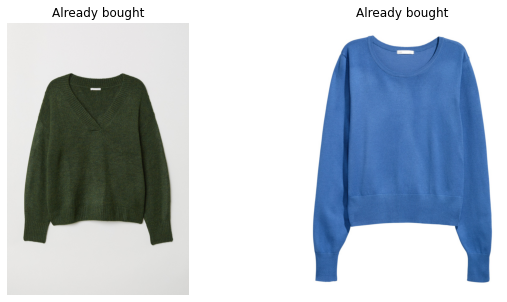

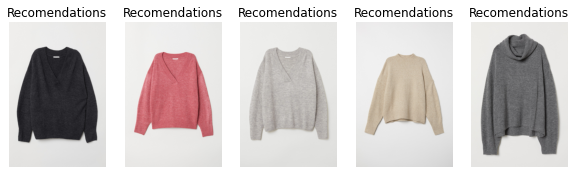

In [27]:
def sample_recommendation_with_image(model, transactions_df, articles_df, article_dict, num, user_ids):

    items = transactions_df.article_id_enc.unique()
    #print(items[:10])

    for user_id in user_ids:

        print("  Recomendations for user_id =", user_id)

        bought = transactions_df[transactions_df["customer_id_enc"] == user_id]["article_id"].values

        # make prediction 
        scores = model.predict(np.ones(len(items)) * user_id, items)
        
        # n-top score 
        num_of_cand = 50
        argsort_scores_idx = np.argsort(scores)[-num_of_cand:]
        argsort_scores_idx = np.flip(argsort_scores_idx)

        
        recomended = []
        k = 1
        for ind in argsort_scores_idx:
            ii = article_dict[items[ind]]
            
            # check if already bought
            if ii in bought:
                continue
            else: k+=1
                
            recomended.append(ii)

            if k > num: break
        #print()
    
    #print("Already bought")
    
    img_list_bought = []
    for id in bought:
        image_path = "../input/h-and-m-personalized-fashion-recommendations/images/0{}/0{}.jpg".format(str(id)[:2], id)
        #print(image_path)
        img = Image.open(image_path)
        img_list_bought.append(img)

    plt.figure(figsize=(10,5))
    for j in range(len(bought)):
        plt.subplot(1, len(bought), j+1)
        plt.axis('off')
        plt.imshow(img_list_bought[j])
        plt.title("Already bought", fontdict=None, loc='center')

    img_list_recomended = [] 
    for id in recomended:
        image_path = "../input/h-and-m-personalized-fashion-recommendations/images/0{}/0{}.jpg".format(str(id)[:2], id)
        #print(image_path)
        img = Image.open(image_path)
        img_list_recomended.append(img)

    plt.figure(figsize=(10,20))
    for j in range(len(recomended)):
        plt.subplot(1, len(recomended), j+1)
        plt.axis('off')
        plt.imshow(img_list_recomended[j])  
        
        plt.title("Recomendations", fontdict=None, loc='center')    
    #return bought, recomended

sample_recommendation_with_image(model, transactions_df_sample, articles_df.set_index("article_id"), article_dict, 5, [8])


  Recomendations for user_id = 22


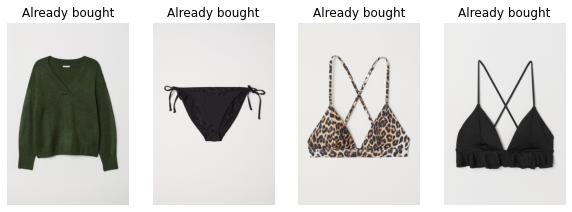

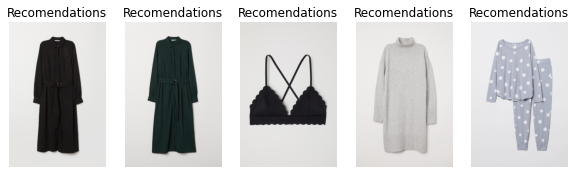

In [28]:
sample_recommendation_with_image(model, transactions_df_sample, articles_df.set_index("article_id"), article_dict, 5, [22])

  Recomendations for user_id = 1511


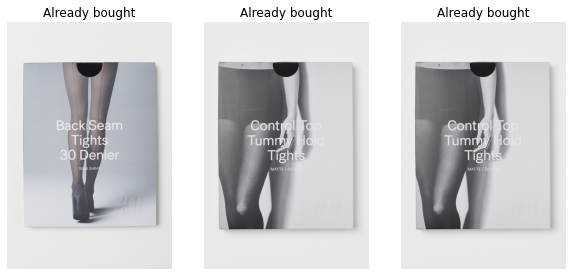

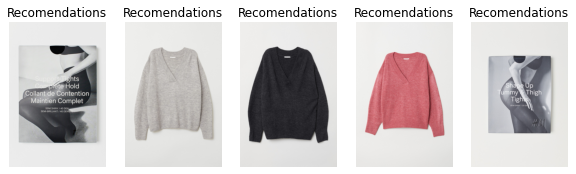

In [29]:
sample_recommendation_with_image(model, transactions_df_sample, articles_df.set_index("article_id"), article_dict, 5, [1511])

  Recomendations for user_id = 4225


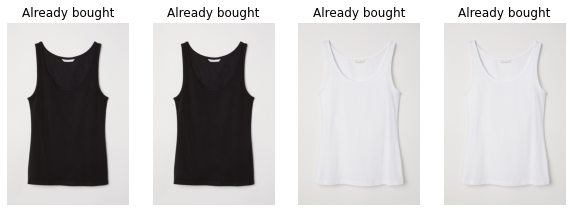

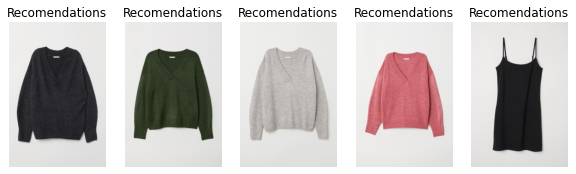

In [30]:
sample_recommendation_with_image(model, transactions_df_sample, articles_df.set_index("article_id"), article_dict, 5, [4225])

  Recomendations for user_id = 9812


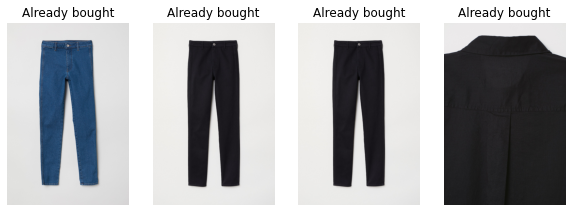

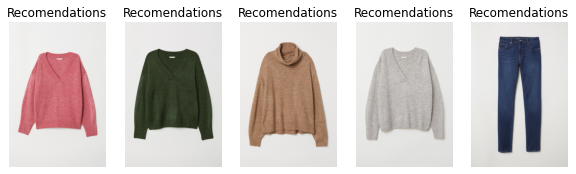

In [31]:
sample_recommendation_with_image(model, transactions_df_sample, articles_df.set_index("article_id"), article_dict, 5, [9812])